## Initial Local Creation of Bayesian Network

## HC + BDs

The experimentation and testing of the initial simple Bayesian Network on a smaller dataset for testing

In [1]:
import pgmpy
import pandas as pd
import networkx as nx
from matplotlib import pyplot as plt
import numpy as np
import sys
sys.path.insert(0,"..")
from Data.DataPreprocessing import DataPreprocessing as myData
from pgmpy import estimators
from pgmpy.inference import VariableElimination
from sklearn.metrics import f1_score, accuracy_score, roc_curve, precision_score, recall_score, roc_auc_score, balanced_accuracy_score
from pgmpy.metrics import correlation_score, log_likelihood_score, structure_score
print(np.__version__)

c:\Users\zachs\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


1.26.1


### Data importing and preprocessing

In [2]:
loaded_data = myData.load_data()
#display(loaded_data)
data = myData.preprocess_data(loaded_data)
train_data, test_data = myData.split_data(data,num_rows = 1000)

feature_states = myData.get_feature_states(data)


c:\Users\zachs\Documents\CSHons\ResearchReport\Research_Code\Honours-Research\HC_differentScores\..\Data\DataPreprocessing.py:14: DtypeWarning: Columns (0,19,49,59,118,129,130,131,134,135,136,139,145,146,147) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv("../Data/accepted_2007_to_2018Q4.csv", engine='c')
c:\Users\zachs\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:1474: ConvergenceWarning: Number of distinct clusters (16) found smaller than n_clusters (31). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
c:\Users\zachs\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\preprocessing\_discretization.py:322: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
c:\Users\zachs\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\preprocessing\_discretization.p

### Structure Learning

In [3]:
scoring_method = estimators.BDsScore(data=train_data,equivalent_sample_size=10) # TODO change sample size hyperparameter
est = estimators.HillClimbSearch(data=train_data, use_cache = True)
estimated_model = est.estimate(
    scoring_method=scoring_method, max_iter=int(1e2))
model = pgmpy.models.BayesianNetwork(estimated_model.edges())
model.add_nodes_from(estimated_model.nodes())
print(model.nodes())
print(model.edges())

100%|██████████| 100/100 [00:33<00:00,  2.94it/s]

['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'total_rec_prncp', 'installment', 'total_rec_int', 'term', 'collection_recovery_fee', 'int_rate', 'initial_list_status', 'sub_grade', 'grade', 'annual_inc', 'loan_status', 'last_fico_range_high', 'debt_settlement_flag', 'last_pymnt_amnt', 'total_rec_late_fee', 'purpose', 'title', 'dti', 'application_type', 'delinq_2yrs', 'num_tl_90g_dpd_24m', 'pct_tl_nvr_dlq', 'fico_range_high', 'fico_range_low', 'open_acc', 'num_sats', 'pub_rec', 'pub_rec_bankruptcies', 'tax_liens', 'revol_bal', 'max_bal_bc', 'total_bal_ex_mort', 'revol_util', 'all_util', 'total_pymnt_inv', 'total_pymnt', 'recoveries', 'last_fico_range_low', 'acc_now_delinq', 'tot_cur_bal', 'tot_hi_cred_lim', 'open_act_il', 'num_op_rev_tl', 'open_il_12m', 'open_il_24m', 'num_tl_op_past_12m', 'total_bal_il', 'total_il_high_credit_limit', 'num_il_tl', 'open_rv_12m', 'open_rv_24m', 'num_tl_120dpd_2m', 'total_rev_hi_lim', 'total_bc_limit', 'inq_last_12m', 'mths_since_recent_inq', 'acc_open_p

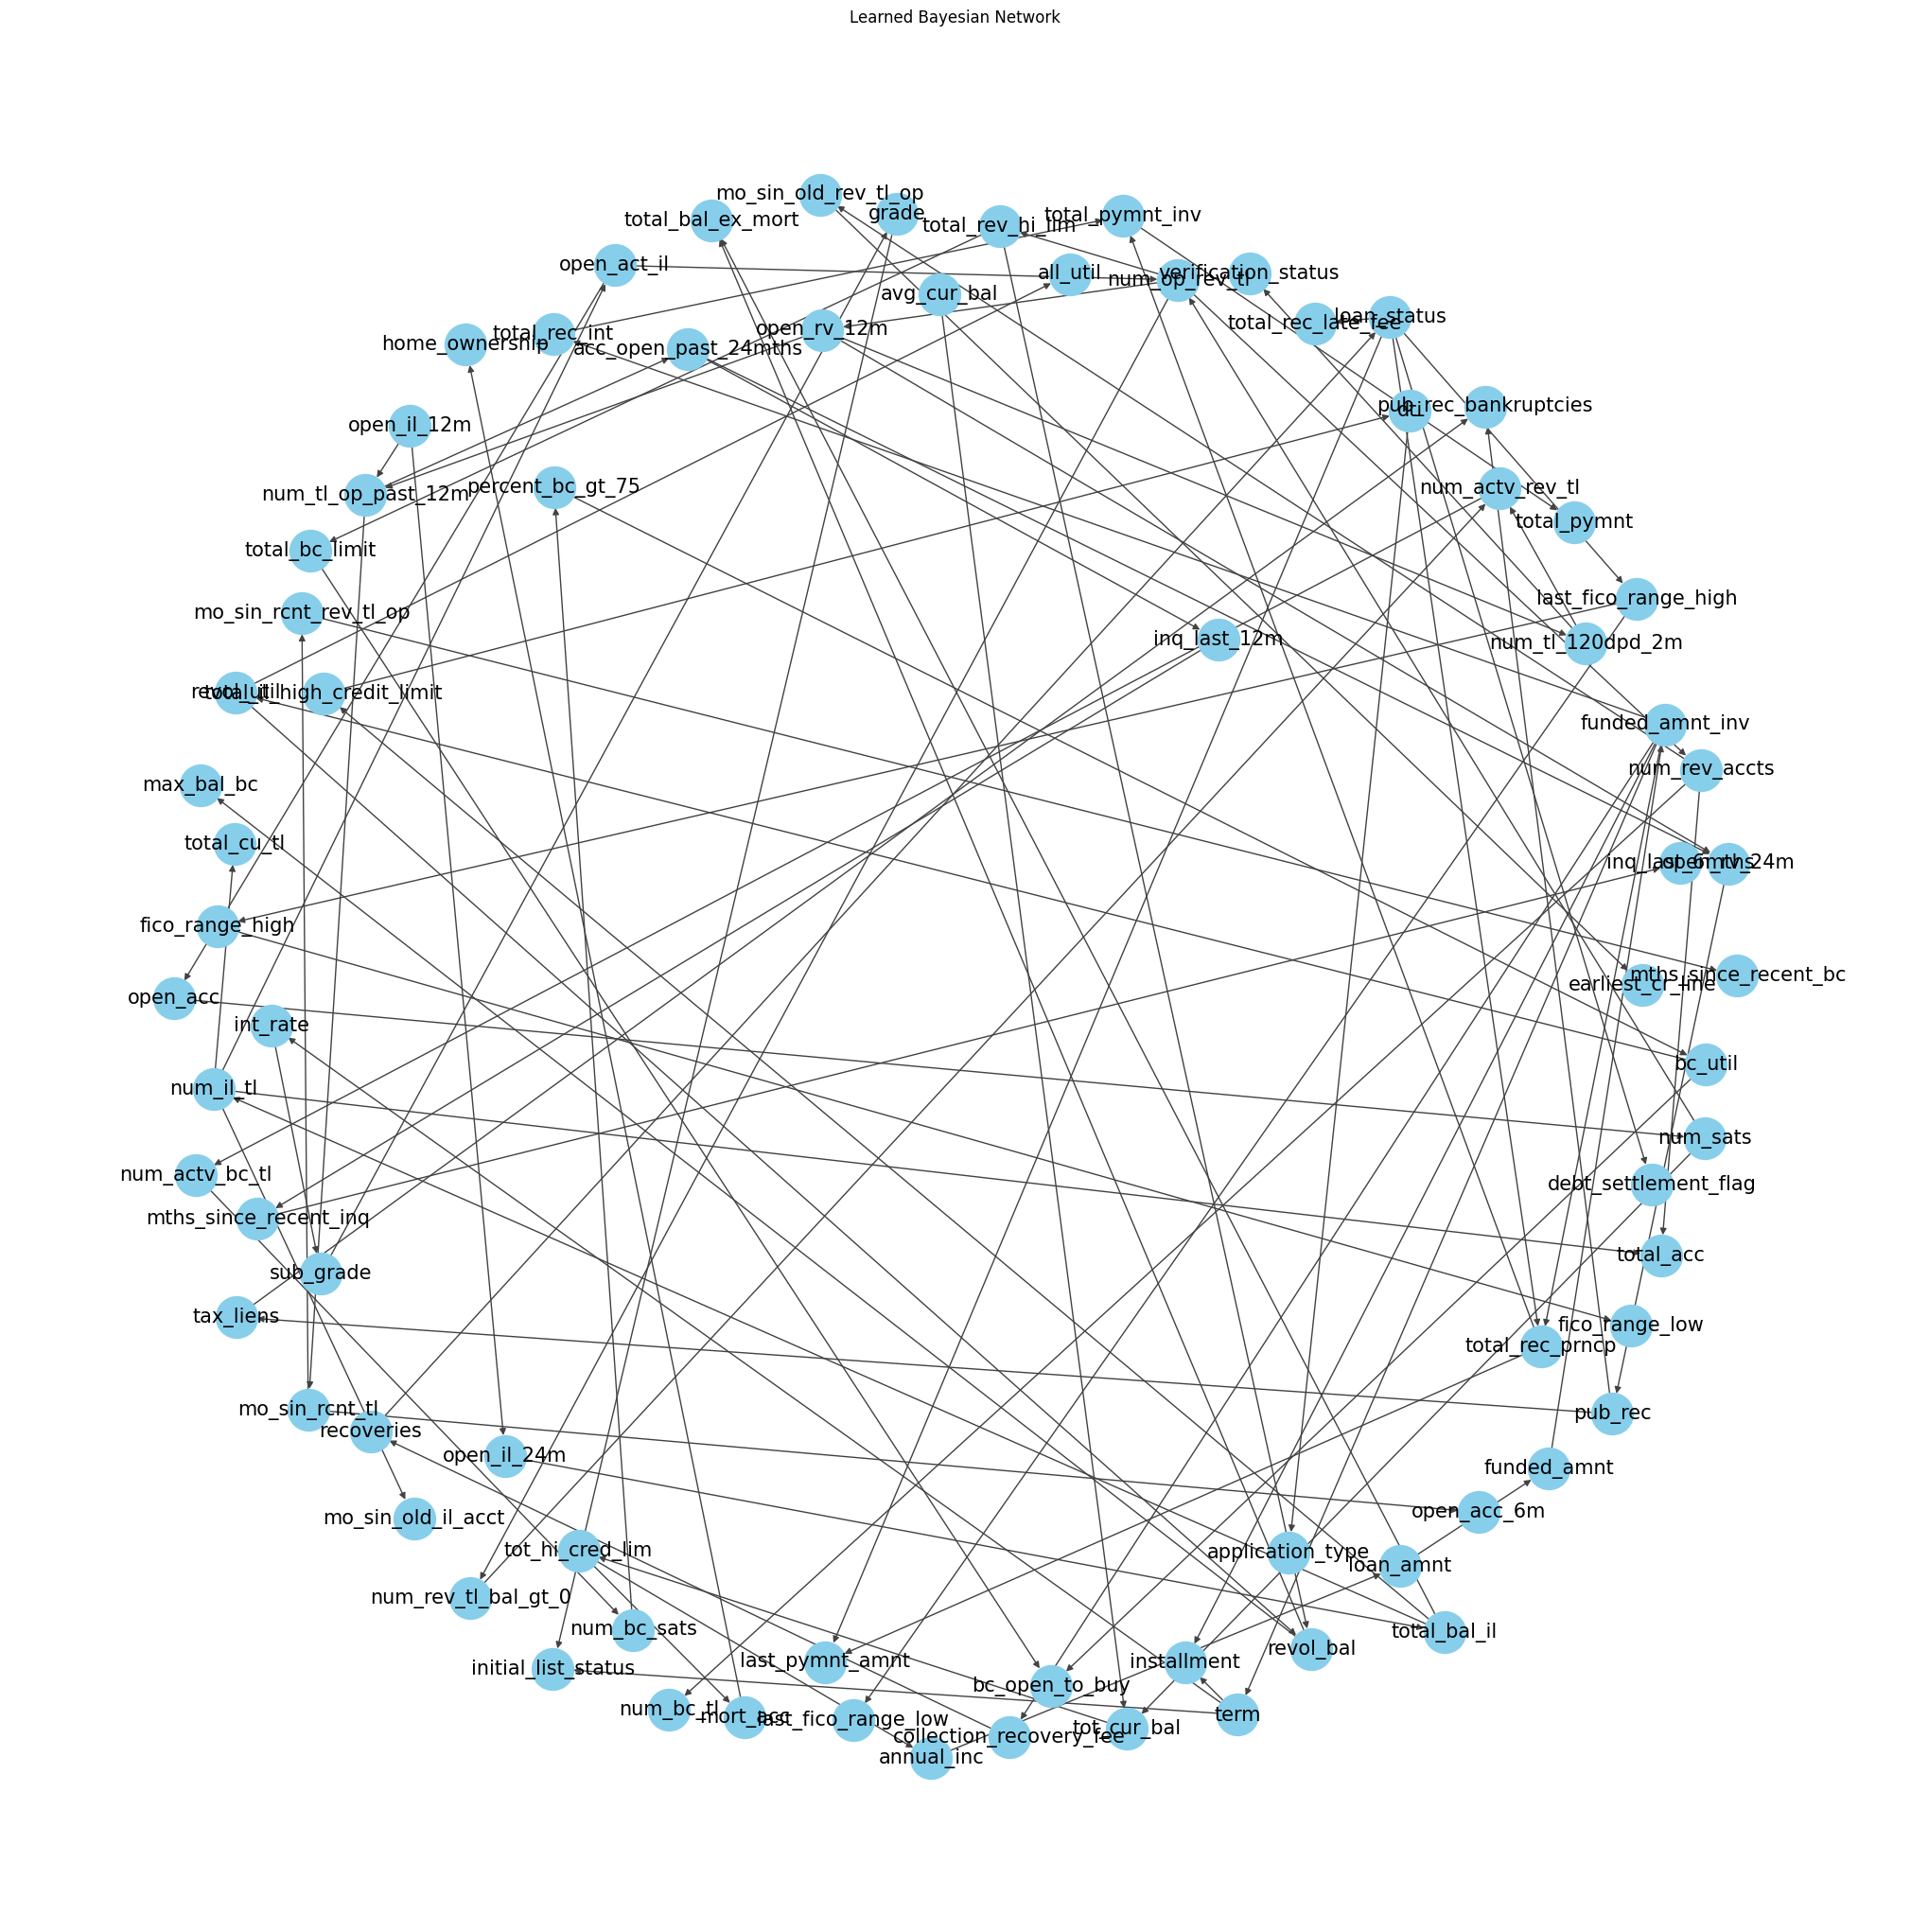

In [4]:
active_trail_nodes = model.active_trail_nodes('loan_status')['loan_status']
active_trail_nodes_list = list(active_trail_nodes)
original_nodes = list(model.nodes())
for node in original_nodes:
    if node not in active_trail_nodes_list:
        model.remove_node(node)
        

nx_graph = nx.DiGraph(model.edges())
pos = nx.spring_layout(nx_graph,2)
plt.figure(figsize=(20, 20))
nx.draw(nx_graph, pos, with_labels=True, node_size=1000, node_color = 'skyblue', edge_color='#424242',font_size=15,font_color='black')
plt.title('Learned Bayesian Network')
plt.show()

###  Parameter Estimation

In [5]:
parameter_estimator = estimators.BayesianEstimator(model,train_data, state_names = feature_states)
parameters = parameter_estimator.get_parameters(n_jobs=6)

for i in range(len(parameters)):
    model.add_cpds(parameters[i])
    #print(parameters[i])

### Inference

In [6]:
def performInference(target_label):
    y_pred = []
    y_true = []    
    testing_evidence_list = myData.get_evidence_list(test_data, target_label=target_label)
    inference = VariableElimination(model)
    for i in range(len(testing_evidence_list)):
        for attribute in list(testing_evidence_list[i].keys()):
            if attribute not in model.nodes():
                del testing_evidence_list[i][attribute]
                
    for i in range(len(testing_evidence_list)):
        loan_status = inference.map_query([target_label], evidence = testing_evidence_list[i], show_progress= True) 
        y_pred.append(loan_status[target_label])
        y_true.append(test_data[target_label].iloc[i])
    
    return y_pred, y_true
    
loan_status_y_pred, loan_status_y_true = performInference('loan_status')    


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it

## Testing

In [7]:
def testModel(y_true, y_pred):
    data_testing_corr_score = model.simulate(int(1e4))
    correlation_score_value = correlation_score(model, data_testing_corr_score, test="log_likelihood", significance_level=0.05)
    log_likelihood_score_value = log_likelihood_score(model, data_testing_corr_score)
    structure_score_value = structure_score(model, data_testing_corr_score, scoring_method="bic")
    print("correlation score: " + str(correlation_score_value))
    print("Log likelihood score: " + str(log_likelihood_score_value))
    print("Structure score: "+ str(structure_score_value))

    accuracy_score_value = accuracy_score(y_true, y_pred)
    f1score_value = f1_score(y_true, y_pred, average = None)
    precisionScore = precision_score(y_true, y_pred,average = None)
    recallScore = recall_score(y_true, y_pred,average = None)
    #roc_auc_score_value =  roc_auc_score(y_true, y_pred,average = None)
    balanced_accuracy_score_value = balanced_accuracy_score(y_true, y_pred, adjusted=True)

    f1_score_macro = f1_score(y_true, y_pred, average='macro')
    precision_score_macro = precision_score(y_true, y_pred, average='macro')
    recall_score_macro = recall_score(y_true, y_pred, average='macro')

    f1_score_weighted = f1_score(y_true, y_pred, average = 'weighted')
    precision_score_weighted = precision_score(y_true, y_pred, average = 'weighted')
    recall_score_weighted = recall_score(y_true, y_pred, average = 'weighted')

    print("accuracy score: "+str(accuracy_score_value))
    print("f1_score: "+str(f1score_value))
    print("precision score: "+str(precisionScore))
    print("recall score: "+str(recallScore))
    #print("roc auc score: "+str(roc_auc_score_value))
    print("balanced_accuracy_score: " + str(balanced_accuracy_score_value))
    print("\n\n")
    print("Macro scores:\n")
    print("recall_score_macro: "+str(recall_score_macro))
    print("f1_score_macro: "+str(f1_score_macro))
    print("precision_score_macro: "+str(precision_score_macro))
    print("\n")
    print("Weighted Scores:\n")
    print("recall_score_weighted: "+str(recall_score_weighted))
    print("f1_score_weighted: "+str(f1_score_weighted))
    print("precision_score_weighted: "+str(precision_score_weighted))
    
    
testModel(loan_status_y_true, loan_status_y_pred)

Generating for node: avg_cur_bal:   0%|          | 0/77 [00:00<?, ?it/s]WARNING:pgmpy:Probability values don't exactly sum to 1. Differ by: 1.1102230246251565e-16. Adjusting values.


Generating for node: total_bal_il:   0%|          | 0/77 [00:00<?, ?it/s]WARNING:pgmpy:Probability values don't exactly sum to 1. Differ by: -2.220446049250313e-16. Adjusting values.
Generating for node: total_il_high_credit_limit:   0%|          | 0/77 [00:00<?, ?it/s]WARNING:pgmpy:Probability values don't exactly sum to 1. Differ by: 1.1102230246251565e-16. Adjusting values.
Generating for node: fico_range_low: 100%|██████████| 77/77 [00:00<00:00, 127.15it/s]
c:\Users\zachs\AppData\Local\Programs\Python\Python312\Lib\site-packages\pgmpy\sampling\base.py:598: FutureWarning: Passing a DataFrame to DataFrame.from_records is deprecated. Use set_index and/or drop to modify the DataFrame instead.
  df = pd.DataFrame.from_records(samples)


correlation score: 0.04644412191582003
Log likelihood score: -658067.4467614659
Structure score: -811067.3247773495
accuracy score: 0.98
f1_score: [0.95798319 0.98687664]
precision score: [0.96610169 0.98429319]
recall score: [0.95       0.98947368]
balanced_accuracy_score: 0.9394736842105262



Macro scores:

recall_score_macro: 0.9697368421052631
f1_score_macro: 0.9724299168486292
precision_score_macro: 0.9751974443162659


Weighted Scores:

recall_score_weighted: 0.98
f1_score_weighted: 0.9799422131057147
precision_score_weighted: 0.9799272340047919
